# Per-position Inference and Plotting

model inference on 1000 germline and mutated test sequences; statistical significance and plotting

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm.notebook import tqdm
tqdm.pandas(leave = False)

from transformers import (
    AutoTokenizer,
    EsmTokenizer,
    EsmForMaskedLM,
    pipeline,
)

from itertools import chain
import torch
import torch.nn.functional as F
import scipy

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [3]:
model_dict = {

    # replace with actual model paths
    "uniform": "../models/uniform-250k_model",
    "preferential": "../models/preferential-250k_model",
    
}

# tokenizer
tokenizer = EsmTokenizer.from_pretrained("../tokenizer/vocab.txt")

In [4]:
def infer_and_group_stats(model, tokenizer, seq, cdr):
    losses = []
    predictions = ""
    scores = []
    perplexities = []

    with torch.no_grad():
        sep = "<cls><cls>"
        sep_idx = seq.find(sep)
        heavy = seq[:sep_idx]
        light = seq[sep_idx + len(sep):]
        cdr_mask = cdr[:sep_idx] + cdr[sep_idx + 2:]

        unmasked = tokenizer(seq, return_tensors = "pt").to(device)["input_ids"]
        ranges = [range(sep_idx), range(sep_idx + len(sep), len(seq))]
        total_len = sum(len(i) for i in ranges)

        # model iteratively predicts each residue (skipping over separator tokens)
        for i in chain(*ranges):
        # for i in tqdm(chain(*ranges), total=total_len, leave=False):
            masked = seq[:i] + "<mask>" + seq[i+1:]
            tokenized = tokenizer(masked, return_tensors="pt").to(device)
            mask_pos = (tokenized.input_ids == tokenizer.mask_token_id)[0].nonzero(as_tuple=True)[0]
            labels = torch.where(tokenized.input_ids == tokenizer.mask_token_id, unmasked, -100)
            output = model(**tokenized, labels = labels)
            logits = output.logits

            # predicted aa
            pred_token = logits[0, mask_pos].argmax(axis=-1)
            predictions+=tokenizer.decode(pred_token)

            # prediction confidence
            prob = logits[0, mask_pos].softmax(dim=-1).topk(1)[0].item()
            scores.append(prob)

            # loss
            loss = output.loss.item()
            losses.append(loss)
            
            # perplexity
            ce_loss = F.cross_entropy(logits.view(-1, tokenizer.vocab_size), labels.view(-1)) # i think this is the same as output.loss.item()
            perplexities.append(float(torch.exp(ce_loss)))

        # group stats by region
        # find indices splitting regions (fwrs and cdrs in heavy and light chains)
        cdr_idxs = [0] + [i for i in range(len(cdr_mask)) if cdr_mask[i] != cdr_mask[i-1]] + [len(cdr_mask)]
        cdr_idxs.insert(7, sep_idx)
        
        # accuracy
        predictions_by_region = [predictions[cdr_idxs[n]:cdr_idxs[n+1]] for n in range(len(cdr_idxs)-1)]
        seq_by_region = [seq.replace(sep, "")[cdr_idxs[n]:cdr_idxs[n+1]] for n in range(len(cdr_idxs)-1)]
        region_mean_acc = [sum(true[i] == predict[i] for i in range(len(true)))/len(true) for true, predict in zip(seq_by_region, predictions_by_region)]

        # prediction confidence
        region_mean_scores = [np.mean(scores[cdr_idxs[n]:cdr_idxs[n+1]]) for n in range(len(cdr_idxs)-1)]

        # loss (median)
        region_median_loss = [np.median(losses[cdr_idxs[n]:cdr_idxs[n+1]]) for n in range(len(cdr_idxs)-1)]
        
        # perplexity (median)
        region_median_perplexity = [np.median(perplexities[cdr_idxs[n]:cdr_idxs[n+1]]) for n in range(len(cdr_idxs)-1)]
        
        return {
            "sequence": seq.replace(sep, ""),
            "heavy": heavy,
            "light": light,
            "cdr_indices": cdr_idxs,
            "prediction": predictions,
            "accuracy_by_region": region_mean_acc,
            "score_by_region": region_mean_scores,
            "loss_by_region": region_median_loss,
            "perplexity_by_region": region_median_perplexity,
            "score": scores,
            "loss": losses,
            "perplexity": perplexities
        }

## load test data

In [5]:
# to seed the random state for the splits
seed = 42

# test data separated in unmutated (germline) and mutated (created in `1-inference_data_splitting.csv`)
# or replace with own paths to inference data
germline_test_df = pd.read_csv("./B_germline_annotated_test.csv")
mutated_test_df = pd.read_csv("./B_mutated_annotated_test.csv")

# format 1000 sample sequences for model inference
germline_test_df = germline_test_df.sample(n = 1000, random_state = seed)
mutated_test_df = mutated_test_df.sample(n = 1000, random_state = seed)

data_dict = {
    "germline": germline_test_df,
    "mutated": mutated_test_df,
}

## inference on 1 example sequence

In [6]:
test = germline_test_df.iloc[0]
test

text        QVQLQESGPGLVKPSQTLSLTCTVSGGSISSGSYYWSWIRQPAGKG...
cdr_mask    0000000000000000000000000111111111100000000000...
Name: 967, dtype: object

In [7]:
x = infer_and_group_stats(EsmForMaskedLM.from_pretrained(model_dict["uniform"]).to(device), 
                          tokenizer, 
                          test["text"], 
                          test["cdr_mask"])

Text(0, 0.5, 'perplexity')

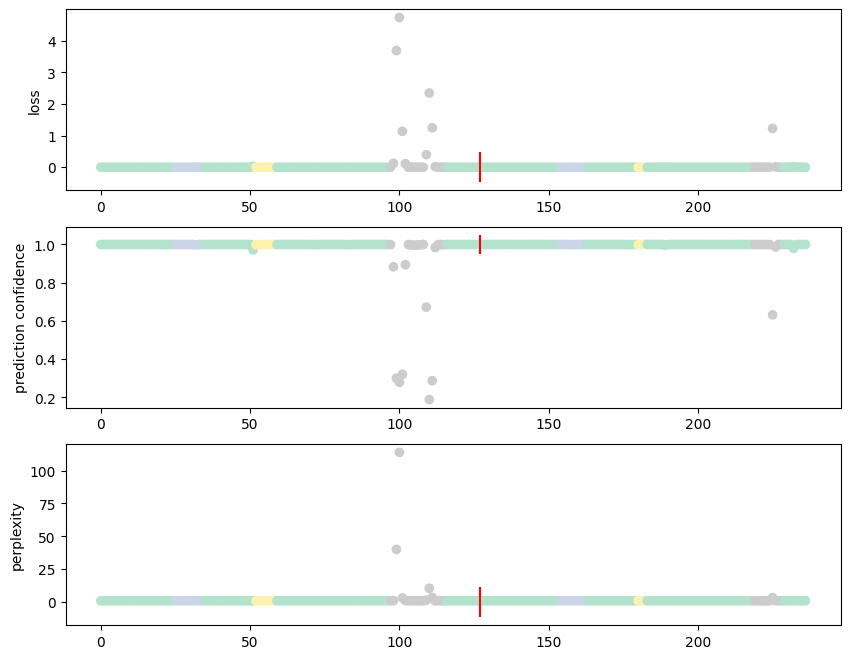

In [8]:
test_stats = pd.DataFrame(list(zip([int(n) for n in test["cdr_mask"]], x["loss"], x["score"], x["perplexity"])), 
                          columns=["cdr", "loss", "score", "perplexity"]).reset_index()

fig, axs = plt.subplots(3, 1, figsize=(10, 8))
axs[0].scatter(test_stats["index"], test_stats["loss"], c=test_stats["cdr"], cmap="Pastel2")
axs[1].scatter(test_stats["index"], test_stats["score"], c=test_stats["cdr"], cmap="Pastel2")
axs[2].scatter(test_stats["index"], test_stats["perplexity"], c=test_stats["cdr"], cmap="Pastel2")

# lines where chains split
axs[0].vlines(test["text"].find("<cls><cls>"), -(max(test_stats["loss"])/10), max(test_stats["loss"])/10, color = "r")
axs[1].vlines(test["text"].find("<cls><cls>"), 0.95, 1.05, color = "r")
axs[2].vlines(test["text"].find("<cls><cls>"), -(max(test_stats["perplexity"])/10), max(test_stats["perplexity"])/10, color = "r")

# label plots
axs[0].set_ylabel("loss")
axs[1].set_ylabel("prediction confidence")
axs[2].set_ylabel("perplexity")

## inference on many (1000) sequences across models

stats aggregated by region

In [9]:
for name, model_path in model_dict.items():
    for seq_type, data in data_dict.items():
    
        model = EsmForMaskedLM.from_pretrained(model_path).to(device)
    
        inference_data = []
        sequences = list(data.iterrows())
    
        for _id, row in tqdm(sequences):
            d = infer_and_group_stats(
                model, 
                tokenizer, 
                row['text'], 
                row['cdr_mask']
            )
            inference_data.append(d)
            
        inference_df = pd.DataFrame(inference_data)
    
        # saving to csv was creating typing problems (lists were strings) when loading in the data for further processing
        inference_df.to_json(f"./results/{name}_{seq_type}_{len(inference_seqs)}.json")

## build plots

In [10]:
model_stats = {
    
    "uniform_germline": "./results/uniform_germline_1000.json",
    "preferential_germline": "./results/preferential_germline_1000.json",
    
    "uniform_mutated": "./results/uniform_mutated_1000.json",
    "preferential_mutated": "./results/preferential_mutated_1000.json",

}

In [11]:
# aggregating and pivoting stats for plotting
def make_stats_df(uniform_path, preferential_path):

    # make local dict for this function only
    model_dict = {
        "uniform": uniform_path,
        "preferential": preferential_path,
    }

    # pivoting data
    stats_list = []

    for _id, data_path in tqdm(model_dict.items()):
        model_df = pd.read_json(data_path)
        model_df = model_df[model_df["cdr_indices"].map(len) == 15] # remove rows without cdr2, would change regional split of stats and not sure how to fix without redoing alignment
        acc_df = pd.DataFrame(list(model_df["accuracy_by_region"]))
        score_df = pd.DataFrame(list(model_df["score_by_region"]))
        loss_df = pd.DataFrame(list(model_df["loss_by_region"]))
        perplexity_df = pd.DataFrame(list(model_df["perplexity_by_region"]))
        
        # the way each metrics' df is made, they should refer to the same instance at the same indices --> important for paired t-test
        for n in acc_df.columns:
            for i in range(len(acc_df)):
                stats_list.append({
                    "seq_id": i,
                    "region": n,
                    "model_id": _id,
                    "accuracy": acc_df.iloc[i, n],
                    "score": score_df.iloc[i, n],
                    "loss": loss_df.iloc[i, n],
                    "perplexity": perplexity_df.iloc[i, n],
                })

    # make into dataframe with renamed regions for plotting
    stats_df = pd.DataFrame(stats_list)
    stats_df.replace({"region": {0:"FRH1", 1:"CDRH1", 2:"FRH2", 3:"CDRH2", 4:"FRH3", 5:"CDRH3", 6:"FRH4",
                                 7:"FRL1", 8:"CDRL1", 9:"FRL2", 10:"CDRL2", 11:"FRL3", 12:"CDRL3", 13:"FRL4"}}, inplace=True)
    return stats_df

In [12]:
# statistical significance
# dependent t-test --> each model performed inference on the same 1000 sequences, so samples are paired
def dep_ttest(data, col_name, model_1, model_2, save_tstats=False, alternative="two-sided"):
    # split comparisons by Ab region
    regions = data["region"].unique()

    # perform dependent t-test
    pvals = []
    if save_tstats:
        tstats = []
    for r in regions:
        stat, pval = scipy.stats.ttest_rel(
            data[(data["region"] == r) & (data["model_id"] == model_1)][col_name],
            data[(data["region"] == r) & (data["model_id"] == model_2)][col_name],
            alternative=alternative,
        )
        pvals.append(pval)
        if save_tstats:
            tstats.append(stat)

    return (pvals, tstats) if save_tstats else pvals

# for plotting, change p-values into asterisks, includes argument for multiple testing correction
def convert_pvalue_to_asterisks(pvalue, n_tests = 1):
    if pvalue <= 0.0001/n_tests:
        return "****"
    elif pvalue <= 0.001/n_tests:
        return "***"
    elif pvalue <= 0.01/n_tests:
        return "**"
    elif pvalue <= 0.05/n_tests:
        return "*"
    return "" #"ns"

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

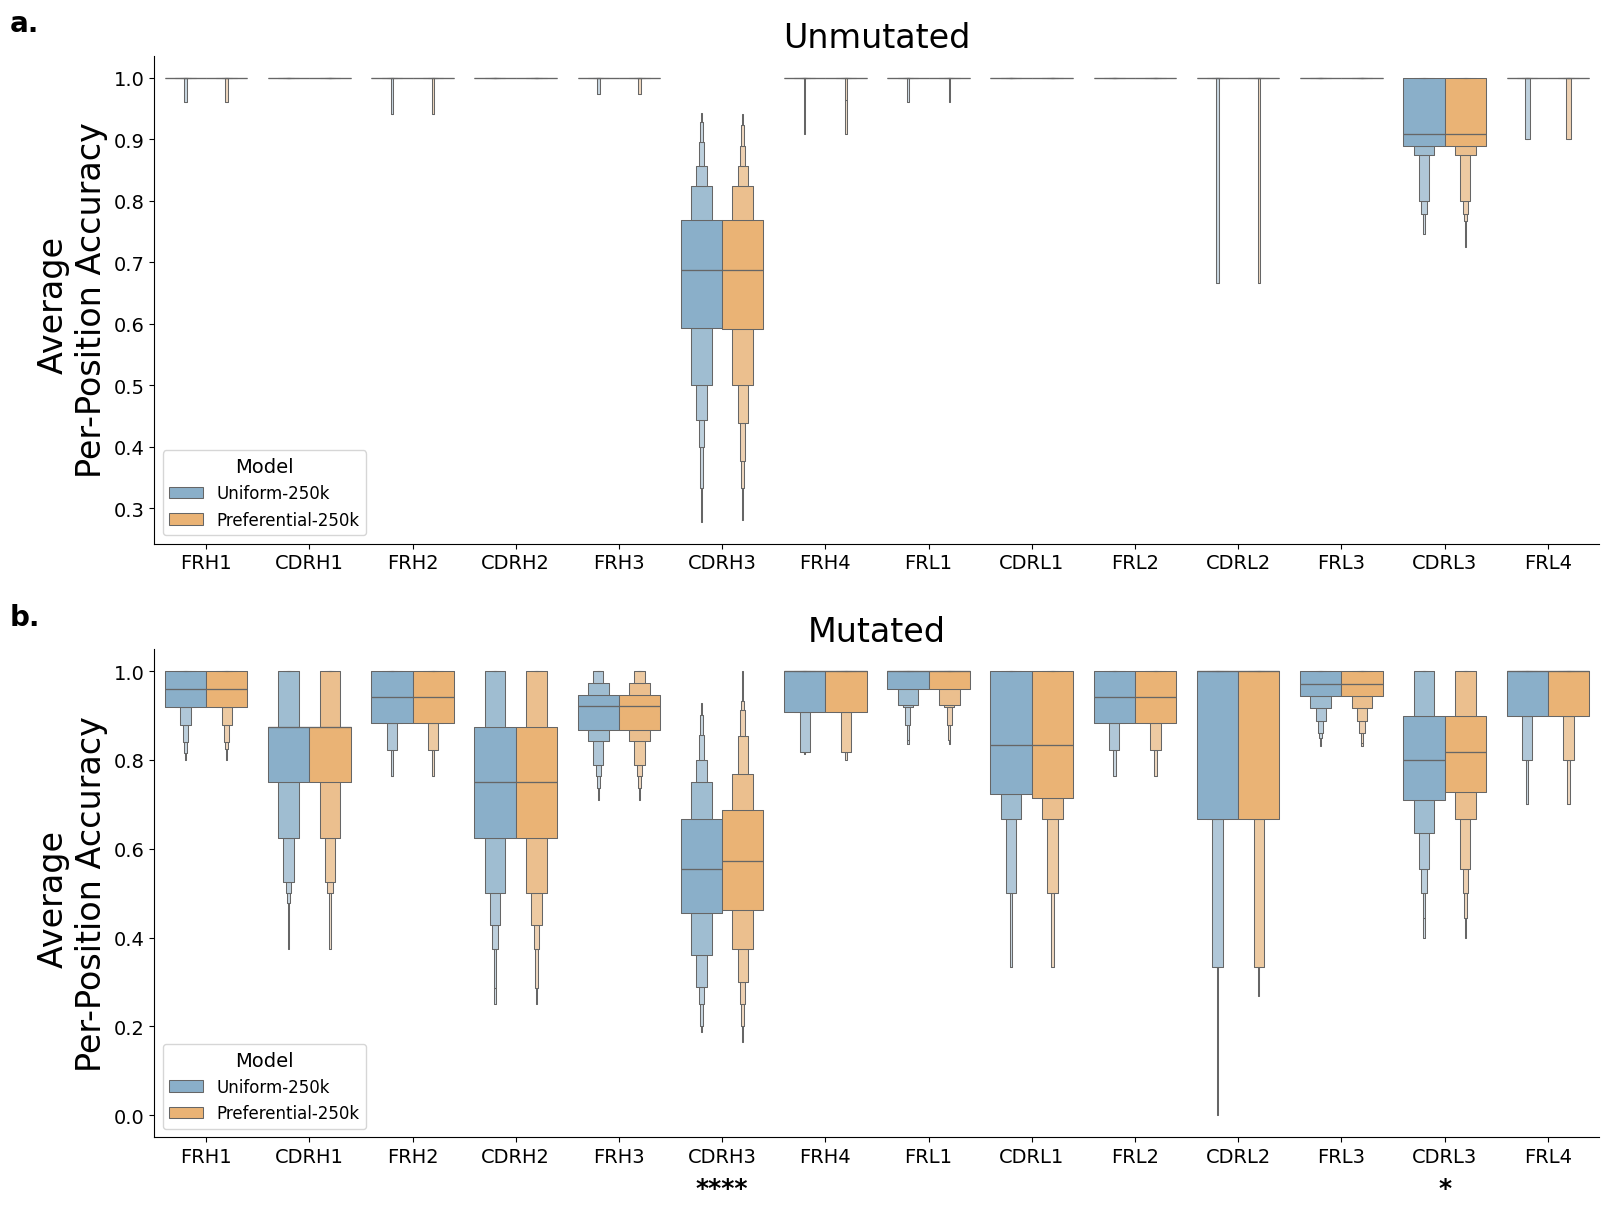

In [13]:
# consolidate stats and calculate statistical significance 
# note: can replace "accuracy" with a different inference metric ("score", "loss", "perplexity")
g_data = make_stats_df(model_stats["uniform_germline"], model_stats["preferential_germline"])
g_pvals = dep_ttest(g_data, "accuracy", "uniform", "preferential")
m_data = make_stats_df(model_stats["uniform_mutated"], model_stats["preferential_mutated"])
m_pvals = dep_ttest(m_data, "accuracy", "uniform", "preferential")

plots = {
    "a.": {
        "title": "Unmutated",
        "data": g_data,
        "pvals": g_pvals,
        "pval_offset": 0.15,
    },
    "b.": {
        "title": "Mutated",
        "data": m_data,
        "pvals": m_pvals,
        "pval_offset": -0.18,
    },
}

# plotting
fig, ax = plt.subplot_mosaic([['a.'], ['b.'],],
                              layout='constrained',
                              figsize=(16, 12),
                              gridspec_kw={"wspace": 0.05, "hspace": 0.05},
                             )
for label, x in plots.items():
    title = x["title"]
    data = x["data"]
    pvals = x["pvals"]
    offset = x["pval_offset"]

    # main plot
    sns.boxenplot(x="region", y="accuracy", hue="model_id", 
              data=data, ax=ax[label], 
              palette=[sns.color_palette("Set3")[4], sns.color_palette("Set3")[5]], 
              showfliers=False)
    
    # p-values (multiple testing with 14 regions
    asterisks = [convert_pvalue_to_asterisks(p, len(pvals)) for p in pvals]
    for idx, p in enumerate(asterisks):
        ax[label].text(x=idx, y=offset, s=p, 
                       ha="center", fontsize=18, weight="bold")

    # labels
    ax[label].set_title(title, fontsize=24)
    ax[label].set_xlabel("", size=24)
    ax[label].set_ylabel("Average \nPer-Position Accuracy", size=24)
    ax[label].tick_params(labelsize=14)
    ax[label].legend(handles=ax[label].get_legend_handles_labels()[0], 
                     labels = ["Uniform-250k", "Preferential-250k"],
                     loc = "lower left",
                     title="Model", title_fontsize=14, fontsize=12)
    ax[label].annotate(label, xy=(-0.1, 1.05), xycoords="axes fraction", 
                       fontsize=20, weight="bold")

sns.despine()
plt.savefig("./results/inference.png", bbox_inches='tight')